In [ ]:
#declare libraries
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import random

#untuk gambar dan plot
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#untuk esktraksi file
from zipfile import ZipFile

#untuk membangun model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

**IMPORTING DATA AND EXTRACT ZIP FROM GOOGLE DRIVE**

In [ ]:
#import dataset dari drive
from google.colab import drive
drive.mount('/content/drive')

local_zip = ZipFile("/content/drive/MyDrive/Eyetify.zip", 'r')
local_zip.extractall("/tmp/training")
local_zip.close()

Mounted at /content/drive


**IMAGE GENERATOR**

In [ ]:
train_dir  = "/tmp/training/Eyetify"

def train_val_generators(TRAINING_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                      horizontal_flip=False,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      validation_split = 0.2,
                                      fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      class_mode="categorical",
                                                      color_mode ="rgb",
                                                      batch_size=32,
                                                      subset = "training",
                                                       shuffle = True,
                                                      target_size=(160,160))


  # validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                                class_mode="categorical",
                                                                color_mode ="rgb",
                                                                batch_size=32,
                                                                subset = "validation",
                                                                shuffle = False,
                                                                target_size=(160,160))

  return train_generator, validation_generator


train_generator, validation_generator = train_val_generators(train_dir)
train_generator.class_indices

Found 1249 images belonging to 8 classes.
Found 310 images belonging to 8 classes.


{'bulging': 0,
 'cataract': 1,
 'conjunctivitis': 2,
 'crossed': 3,
 'glaucoma': 4,
 'hordeolum': 5,
 'normal': 6,
 'uveitis': 7}

**READING IMAGES**

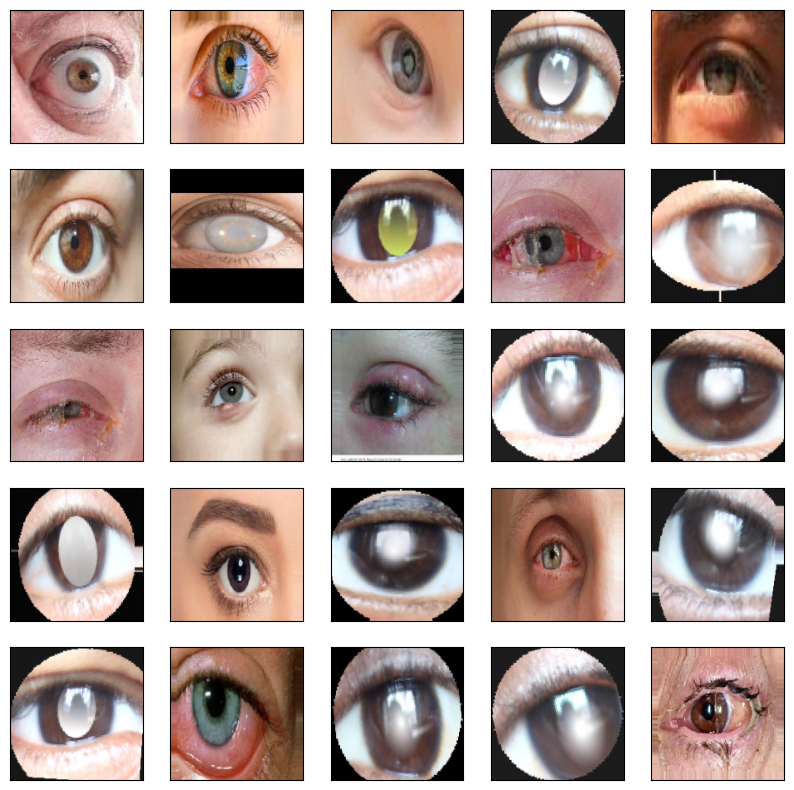

In [ ]:
images, labels = train_generator.next()
class_name = ['bulging', 'cataract','conjunctivitis', 'crossed', 'glaucoma','hordeolum','normal','uveitis']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    image = images[i]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # plt.title(class_names[labels[i].argmax()])
    plt.imshow(image)
plt.show()

**BUILD THE MODEL**

In [ ]:
# # #model using a inceptionV3
pretrained_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(160,160,3))

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate = 0.7)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
pred = Dense(8, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=pred)

for layer in pretrained_model.layers:
  layer.trainable = False

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 79, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
model.compile(Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

initial_epoch = 40

history = model.fit(train_generator,
          epochs = initial_epoch,
          validation_data = validation_generator,
          steps_per_epoch = len(train_generator))

Epoch 1/40
40/40 [==============================] - 34s 485ms/step - loss: 2.7135 - accuracy: 0.4011 - val_loss: 1.3543 - val_accuracy: 0.5613
Epoch 2/40
40/40 [==============================] - 14s 348ms/step - loss: 1.7084 - accuracy: 0.5693 - val_loss: 0.9433 - val_accuracy: 0.6677
Epoch 3/40
40/40 [==============================] - 14s 350ms/step - loss: 1.4655 - accuracy: 0.6189 - val_loss: 0.8689 - val_accuracy: 0.7258
Epoch 4/40
40/40 [==============================] - 16s 403ms/step - loss: 1.3160 - accuracy: 0.6509 - val_loss: 0.8144 - val_accuracy: 0.7516
Epoch 5/40
40/40 [==============================] - 14s 343ms/step - loss: 1.1832 - accuracy: 0.6725 - val_loss: 0.7872 - val_accuracy: 0.7226
Epoch 6/40
40/40 [==============================] - 14s 342ms/step - loss: 1.1252 - accuracy: 0.6829 - val_loss: 0.8016 - val_accuracy: 0.7516
Epoch 7/40
40/40 [==============================] - 14s 340ms/step - loss: 1.0555 - accuracy: 0.6990 - val_loss: 0.7988 - val_accuracy: 0.7677

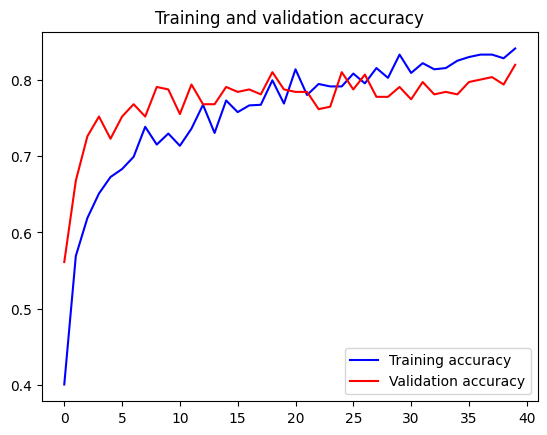

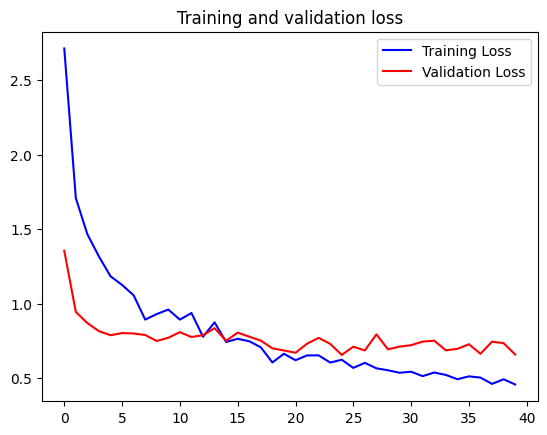

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, 'b', label='Training accuracy')
plt.plot(val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(loss, 'b', label='Training Loss')
plt.plot(val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#fine tune
fine_tune = 100
# fine_tune = 50

for layer in pretrained_model.layers[:fine_tune]:
  layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 79, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 79, 79, 32)           0         ['batch_normalization[0][0

In [ ]:
tuning_epoch = 20
total_epoch = initial_epoch + tuning_epoch

history_fine = model.fit(train_generator,
                     validation_data = validation_generator,
                     epochs = total_epoch,
                     initial_epoch = len(history.epoch))

Epoch 41/60
40/40 [==============================] - 23s 402ms/step - loss: 0.4435 - acc: 0.8431 - val_loss: 0.6885 - val_acc: 0.7903
Epoch 42/60
40/40 [==============================] - 14s 341ms/step - loss: 0.4824 - acc: 0.8327 - val_loss: 0.6666 - val_acc: 0.8065
Epoch 43/60
40/40 [==============================] - 13s 333ms/step - loss: 0.4674 - acc: 0.8319 - val_loss: 0.6782 - val_acc: 0.8065
Epoch 44/60
40/40 [==============================] - 13s 329ms/step - loss: 0.4252 - acc: 0.8535 - val_loss: 0.7471 - val_acc: 0.7871
Epoch 45/60
40/40 [==============================] - 13s 333ms/step - loss: 0.4704 - acc: 0.8391 - val_loss: 0.6907 - val_acc: 0.8065
Epoch 46/60
40/40 [==============================] - 14s 343ms/step - loss: 0.4323 - acc: 0.8455 - val_loss: 0.6686 - val_acc: 0.8129
Epoch 47/60
40/40 [==============================] - 14s 343ms/step - loss: 0.4162 - acc: 0.8639 - val_loss: 0.7382 - val_acc: 0.7903
Epoch 48/60
40/40 [==============================] - 14s 340ms

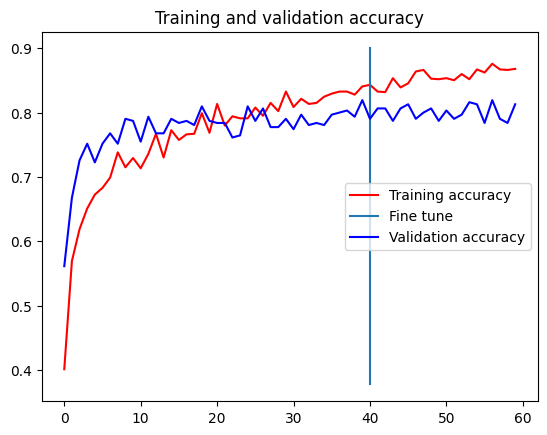

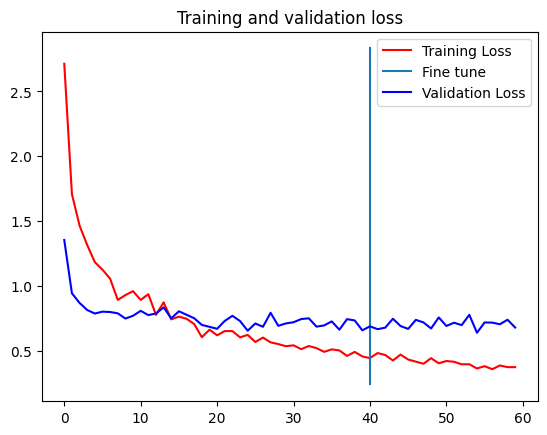

In [ ]:
#plot training dan validation accuracy setelah fine tuning
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.plot(acc, 'r', label='Training accuracy')
plt.plot([len(history.epoch), len(history.epoch)], plt.ylim(), label='Fine tune')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(loss, 'r', label='Training Loss')
plt.plot([len(history.epoch), len(history.epoch)], plt.ylim(), label='Fine tune')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**TESTING**

10/10 [==============================] - 4s 243ms/step


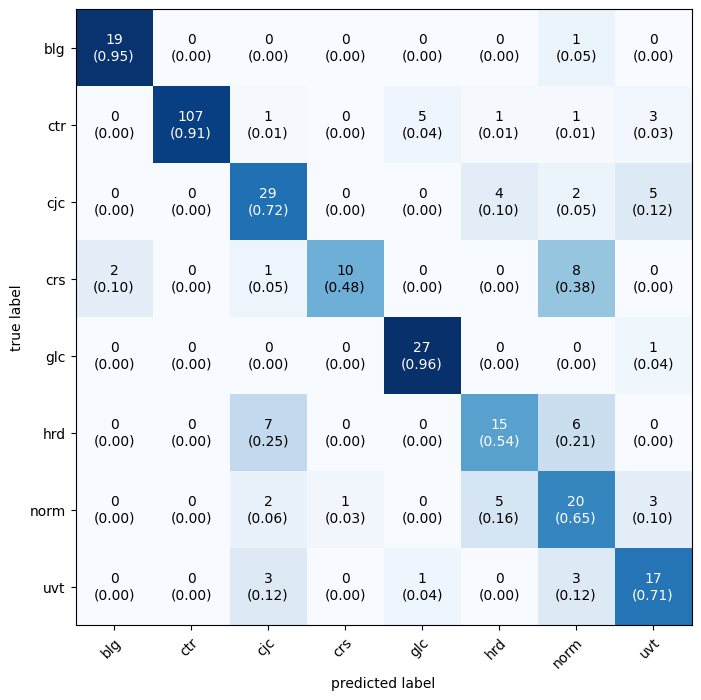

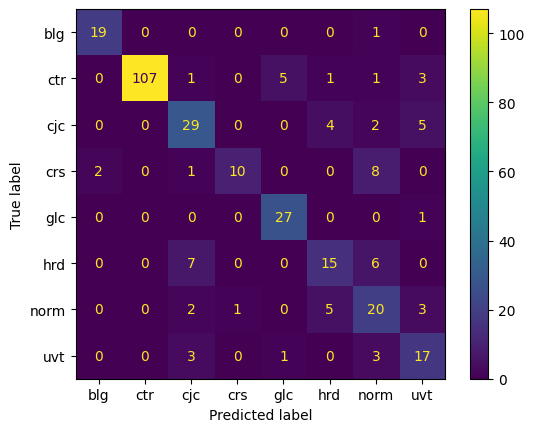

0.7870967741935484
[0.9047619  1.         0.6744186  0.90909091 0.81818182 0.6
 0.48780488 0.5862069 ]
[0.95       0.90677966 0.725      0.47619048 0.96428571 0.53571429
 0.64516129 0.70833333]
[0.92682927 0.95111111 0.69879518 0.625      0.8852459  0.56603774
 0.55555556 0.64150943]


In [ ]:
y_testgen = validation_generator.classes
y_pred1 = model.predict(validation_generator)
y_pred1 = np.argmax(y_pred1, axis=1)

cm = confusion_matrix(y_testgen, y_pred1)
plot_confusion_matrix(conf_mat = cm,figsize=(8,8),class_names = ['blg', 'ctr','cjc', 'crs', 'glc','hrd','norm','uvt'],
                      show_normed = True);

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blg', 'ctr','cjc', 'crs', 'glc','hrd','norm','uvt'])
cm_display.plot()
plt.show()

accuracy= accuracy_score(validation_generator.classes, y_pred1)
precision = precision_score(validation_generator.classes, y_pred1, average=None)
recall= recall_score(validation_generator.classes, y_pred1, average=None)
f1 = f1_score(validation_generator.classes, y_pred1, average=None)
print(accuracy)
print(precision)
print(recall)
print(f1)

1/1 [==============================] - 1s 1s/step


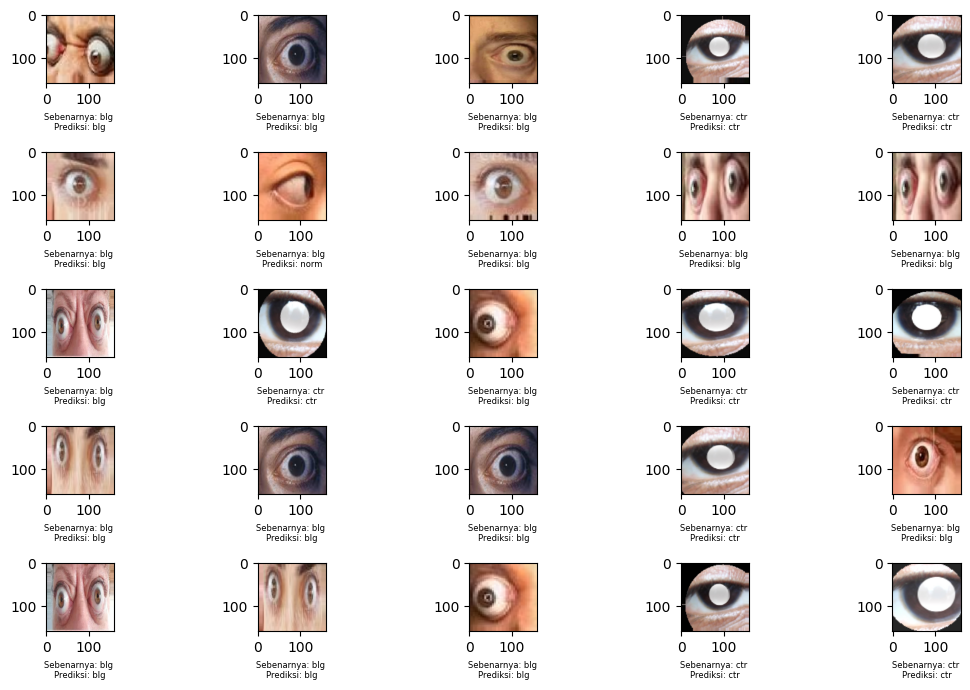

In [ ]:
import random

class_names = ['blg', 'ctr','cjc', 'crs', 'glc','hrd','norm','uvt']
y_pred2 = model.predict(images)
plt.figure(figsize=(11, 7))

for i in range(25):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]

    label = class_names[labels[sample_index].argmax()]
    pred_label = class_names[y_pred2[sample_index].argmax()]

    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Sebenarnya: {} \nPrediksi: {}".format(label, pred_label), fontsize=6)

plt.tight_layout()
plt.show()

**DOWNLOAD MODEL**

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# model.save("/content/drive/MyDrive/modeleyetify.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# #Convert to tflite
model.save("modeleyetify.h5")
model_eyetify = tf.keras.models.load_model("modeleyetify.h5")

# converter = tf.lite.TFLiteConverter.from_keras_model(model_eyetify)
# tflite_model = converter.convert()

# # Save the model.
# with open('modeleyetify.tflite', 'wb') as f:
#   f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
!sudo tensorflowjs_converter
!tensorflowjs_converter --input_format=keras '/content/drive/MyDrive/modeleyetify.h5' "/content/drive/MyDrive/eyetifyjson"

2024-06-09 17:57:45.809168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 17:57:47.871288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 894, in convert
    raise ValueError(
ValueError: Missing input